# 1 K-Means 实现

## 导包

In [13]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator
import matplotlib.pyplot as plt

## 数据

数据的前 5 行:
         X1        X2
0  1.842080  4.607572
1  5.658583  4.799964
2  6.352579  3.290854
3  2.904017  4.612204
4  3.231979  4.939894


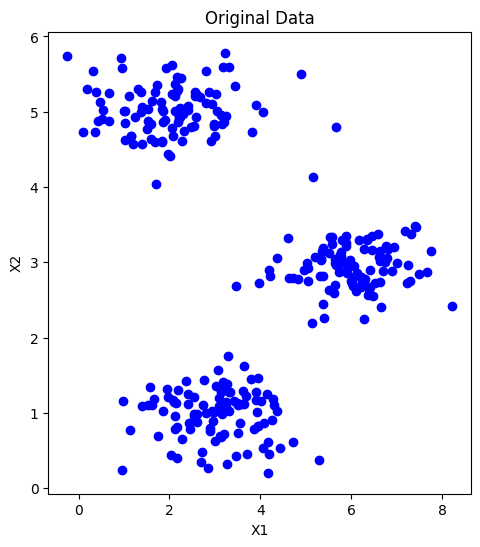

In [14]:
url = "clusterData/ex7data2.csv"  
data = pd.read_csv(url, header=None, names=["X1", "X2"])
print("数据的前 5 行:")
print(data.head())
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data["X1"], data["X2"], c='blue', marker='o')
plt.title('Original Data')
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()

## K - Means

In [15]:
class KMeans:
    def __init__(self, n_clusters, max_iter=100, random_state=None, noise_threshold=None):
        """
        初始化KMeans类
        :param n_clusters: 聚类的簇数
        :param max_iter: 最大迭代次数
        :param random_state: 随机种子，用于初始化聚类中心
        :param noise_threshold: 噪声点的阈值，动态计算
        """
        
        self.n_clusters = n_clusters  
        self.max_iter = max_iter  
        self.random_state = random_state  
        self.noise_threshold = noise_threshold 
        self.centroids = None  
        self.labels = None  

    def initialize_centroids(self, X):
        """
        随机初始化聚类中心
        :param X: 输入数据
        :return: 随机初始化的聚类中心
        """
        np.random.seed(self.random_state)  
        random_idx = np.random.permutation(X.shape[0])  
        centroids = X[random_idx[:self.n_clusters]]  
        return centroids

    def compute_centroids(self, X, labels):
        """
        计算新的聚类中心
        :param X: 输入数据
        :param labels: 当前聚类标签
        :return: 新的聚类中心
        """
        centroids = []  
        for i in range(self.n_clusters):  
            cluster_points = X[labels == i]  
            if len(cluster_points) > 0:  
                centroids.append(cluster_points.mean(axis=0))  # 计算当前簇的均值作为新的聚类中心
            else:
                centroids.append(self.centroids[i])  
        return np.array(centroids)  

    def compute_labels(self, X, centroids):
        """
        计算每个点的聚类标签
        :param X: 输入数据
        :param centroids: 当前聚类中心
        :return: 聚类标签
        """
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)  # 计算每个点到每个聚类中心的距离,ns,nf;ns,1,nf;ns,nc,nf;
        labels = np.argmin(distances, axis=1)  # 为每个点分配距离最近的聚类中心的标签
        return labels

    def compute_noise_points(self, X, labels, centroids):
        """
        计算噪声点
        :param X: 输入数据
        :param labels: 当前聚类标签
        :param centroids: 当前聚类中心
        :return: 噪声点的索引
        """
        
        if self.noise_threshold is None:  # 噪声阈值未指定
            # 动态计算噪声点阈值，例如使用所有点到最近聚类中心的平均距离
            distances = np.linalg.norm(X - centroids[labels], axis=1)  # 计算每个点到其聚类中心的距离
            self.noise_threshold = np.mean(distances) * 2  # 两倍平均距离作为阈值

        noise_points = []  
        for i in range(X.shape[0]):  
            if labels[i] == -1:  
                continue  
            distance = np.linalg.norm(X[i] - centroids[labels[i]])  
            
            if distance > self.noise_threshold:  
                noise_points.append(i)  
        return noise_points

    def fit(self, X):
        """
        执行算法
        :param X: 输入数据
        """
        global labels
        self.centroids = self.initialize_centroids(X)  
        for _ in range(self.max_iter):  
            labels = self.compute_labels(X, self.centroids)  
            new_centroids = self.compute_centroids(X, labels)  
            if np.all(self.centroids == new_centroids):  # 新旧一致
                break  
            self.centroids = new_centroids  # 更新

        # 噪声点
        noise_points = self.compute_noise_points(X, labels, self.centroids)  
        labels = labels.copy()  # 复制当前标签
        labels[noise_points] = -1  # 噪声点记为-1
        self.labels = labels  # 更新

## 聚类结果

In [21]:
# 数据标准化
scaler = StandardScaler()  
scaled_data = scaler.fit_transform(np.array(list(zip(data["X1"], data["X2"]))))  # X1和X2列组合成二维数组，标准化

kmeans_manual = KMeans(n_clusters=3, random_state=42)  
kmeans_manual.fit(scaled_data)  

labels = kmeans_manual.labels  
centroids = kmeans_manual.centroids  

data["Cluster"] = labels  # 新的列"Cluster"

fig = px.scatter( 
    data,  
    x="X1",  
    y="X2",  
    color="Cluster",  
    title="K-Means 聚类结果（包含噪声点）",  
    labels={"X1": "特征 1", "X2": "特征 2", "Cluster": "簇"},  
)

centroids_original = scaler.inverse_transform(centroids)  
fig.add_scatter(  
    x=centroids_original[:, 0],  
    y=centroids_original[:, 1],  
    mode="markers",  
    marker=dict(  
        size=20,  
        color="red",  
        symbol="x",  
        line=dict(width=2, color="DarkSlateGrey"),  
    ),
    name="聚类中心",  
)

noise_data = data[data["Cluster"] == -1]  
if not noise_data.empty:  
    fig.add_scatter(  
        x=noise_data["X1"],  
        y=noise_data["X2"],  
        mode="markers",  
        marker=dict(  
            size=5,  
            color="black",  
            line=dict(width=2, color="black"),  
        ),
        name="噪声点",  # 图例名称
    )

fig.show()  

## 肘部法则

In [29]:
silhouette_avg = silhouette_score(scaled_data, labels)  # 计算轮廓系数
print(f"聚类的轮廓系数: {silhouette_avg:.3f}")  

def compute_inertia(X, centroids, labels):
    """
    计算惯性值（聚类的总平方误差）
    :param X: 输入数据
    :param centroids: 聚类中心
    :param labels: 聚类标签
    :return: 惯性值
    """
    distances = np.linalg.norm(X - centroids[labels], axis=1)  
    
    return np.sum(distances ** 2)  # 计算即惯性值

inertia = []  # 不同簇数下的惯性值
for n in range(1, 20):  
    kmeans_manual = KMeans(n_clusters=n, random_state=42)  
    kmeans_manual.fit(scaled_data)  
    labels = kmeans_manual.labels  
    centroids = kmeans_manual.centroids  
    inertia.append(compute_inertia(scaled_data, centroids, labels))  
    

fig_elbow = px.line(  
    x=range(1, 20),  
    y=inertia,  
    title="肘部法则：选择最佳簇数",  
    labels={"x": "簇数", "y": "惯性"},  
)  
fig_elbow.show()  

聚类的轮廓系数: 0.461


# DBScan

In [18]:
class DBSCAN:
    def __init__(self, eps, min_samples):
        """
        初始化DBSCANManual类
        :param eps: 邻域半径
        :param min_samples: 形成簇所需的最小点数
        """
        self.eps = eps  
        self.min_samples = min_samples  
        self.labels = None  

    def fit(self, X):
        """
        执行DBSCAN聚类算法
        :param X: 输入数据，形状为(n_samples, n_features)
        """
        n_samples = X.shape[0]  # 数据点数量
        visited = np.zeros(n_samples, dtype=bool)  
        cluster_label = 0  
        self.labels = np.zeros(n_samples, dtype=int)  # 初始化标签为0

        for i in range(n_samples):  
            if visited[i]:  
                continue
            visited[i] = True  
            neighbors = self.region_query(X, i)  

            if len(neighbors) < self.min_samples:  # 如果邻域点数量小于min_samples
                self.labels[i] = -1  # 标记该点为噪声点（标签为-1）
            else:  # 如果邻域点数量大于或等于min_samples
                cluster_label += 1  # 给当前簇分配一个新的标签
                self.expand_cluster(X, i, neighbors, cluster_label, visited)  # 扩展该簇

    def region_query(self, X, idx):
        """
        查询当前点的邻域点
        :param X: 输入数据
        :param idx: 当前点的索引
        :return: 邻域点的索引列表
        """
        distances = np.linalg.norm(X - X[idx], axis=1)  
        neighbors = np.where(distances <= self.eps)[0]  
        return neighbors

    def expand_cluster(self, X, idx, neighbors, cluster_label, visited):
        """
        扩展簇
        :param X: 输入数据
        :param idx: 当前点的索引
        :param neighbors: 当前点的邻域点索引列表
        :param cluster_label: 当前簇的标签
        :param visited: 访问标记数组
        """
        self.labels[idx] = cluster_label  # 分配簇标签

        for neighbor in neighbors:  
            if not visited[neighbor]:  
                visited[neighbor] = True  
                neighbor_neighbors = self.region_query(X, neighbor)  # 查询该邻域点的邻域点

                if len(neighbor_neighbors) >= self.min_samples:  
                    self.expand_cluster(X, neighbor, neighbor_neighbors, cluster_label, visited)  
                self.labels[neighbor] = cluster_label  


def find_optimal_eps(data, min_samples=3, percentile=95):
    """使用k-distance图自动寻找最佳eps参数"""
    distances = pdist(data, 'euclidean')  
    dist_matrix = squareform(distances)  
    k_distances = np.sort(dist_matrix)[:, min_samples]  # 获取每个点的第k个最近邻距离
    
    sorted_k_distances = np.sort(k_distances)  # 对第k个最近邻距离进行排序

    # 使用kneed自动检测拐点
    kneedle = KneeLocator(
        x=range(len(sorted_k_distances)),  # x轴是点的索引
        y=sorted_k_distances,  # y轴是排序后的第k个最近邻距离
        S=1.0,  # 灵敏度参数
        curve="convex",  
        direction="increasing"  
    )
    
    # 返回拐点最佳eps，或95%分位数
    return kneedle.knee_y if kneedle.knee else np.percentile(k_distances, percentile)


eps_range = np.linspace(0.1, 1.0, 20)  # 在0.1到1.0之间生成20个等间距的eps值
min_samples_range = range(2, 11)  # min_samples的取值范围是2到10

# 初始化最佳参数和最佳轮廓系数
best_silhouette = -1  # 轮廓系数范围[-1, 1]
best_eps = 0.6  
best_min_samples = 50  

# 遍历不同的 eps 和 min_samples 组合，寻找最佳参数
for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)  
        dbscan.fit(scaled_data)  
        labels = dbscan.labels  
        
        # 计算轮廓系数，评估聚类效果
        if len(set(labels)) > 1:  # 确保有多个簇（否则无法计算轮廓系数）
            silhouette_avg = silhouette_score(scaled_data, labels)  # 计算轮廓系数
            if silhouette_avg > best_silhouette:  
                best_silhouette = silhouette_avg  
                best_eps = eps  
                best_min_samples = min_samples  

# 使用最佳参数进行聚类
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(scaled_data)
labels = dbscan.labels  


data["Cluster"] = labels  # 在原始数据框中添加聚类标签列

# 计算每个簇的聚类中心（使用原始数据）
centers = []  
for cluster in np.unique(labels):
    if cluster != -1:  
        cluster_data = data[data["Cluster"] == cluster]  # 获取当前簇的原始数据
        center = cluster_data[["X1", "X2"]].mean().values  # 计算簇内点的均值作为中心
        centers.append(center) 
        
centers = np.array(centers)  

fig = px.scatter(
    data, 
    x="X1", 
    y="X2",  
    color="Cluster",  
    title="DBSCAN 聚类结果",  
    color_continuous_scale="Viridis",  
    labels={"X1": "特征 1", "X2": "特征 2", "Cluster": "簇"}, 
)

if len(centers) > 0:
    fig.add_scatter(
        x=centers[:, 0],  
        y=centers[:, 1],  
        mode="markers",  
        marker=dict(
            size=20,  
            color="red",  
            symbol="x",  
            line=dict(width=2)  
        ),
        name="聚类中心"  
    )

fig.show()

# 计算聚类效果（轮廓系数）
silhouette_avg = silhouette_score(scaled_data, labels)  
print(f"聚类的轮廓系数: {silhouette_avg:.3f}")  

# 绘制距离排序图以帮助选择 eps
distances = []
for i in range(len(scaled_data)):
    dist = np.sort(np.linalg.norm(scaled_data[i] - scaled_data, axis=1))
    distances.append(dist)

distances = np.array(distances)
k = 3  
fig_dist = px.line(
    x=range(len(distances[:, k])),  
    y=distances[:, k],  
    title="距离排序图（选择 eps）",  
    labels={"x": "点索引", "y": "第 3 个最近邻距离"},  
)
fig_dist.show()

聚类的轮廓系数: 0.677
